# Mask R-CNN With Cityscape Dataset

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import json

import coco
import utils
import model_visualization as modellib
import visualize
from config import Config
from pycocotools import mask as maskUtils  #If running in window, must rebuild

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
# CITYSCAPE_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_cityscape_data_0000.h5")
CITYSCAPE_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_cityscape_data_0019.h5")



C:\ProgramData\anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\anaconda3\envs\py36\lib\site-packages\tensorflow\python\frame

## Configurations

In [2]:
class CityscapeConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cityscape_data"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes
    NUM_CLASSES = 35

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 2048
#     IMAGE_MIN_DIM = 512
#     IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 200  # default value

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100  # small number on small dataset, better smaller than 1000

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5  # bigger number improves validation stats accuracy but slows down

In [3]:
class InferenceConfig(CityscapeConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[512 512]
 [256 256]
 [128 128]
 [ 64  64]
 [ 32  32]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  2048
IMAGE_MIN_DIM                  1024
IMAGE_PADDING                  True
IMAGE_SHAPE                    [2048 2048    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           cityscape_data
NUM_CLASSES                    35
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TR

## Create Model and Load Trained Weights

In [4]:
CITYSCAPE_MODEL_PATH

'C:\\Users\\QUI TRAN\\Mask_RCNN\\Torreshan\\final_code\\logs\\mask_rcnn_cityscape_data_0019.h5'

In [5]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on CITYSCAPE
model.load_weights(CITYSCAPE_MODEL_PATH, by_name=True)

## Class Names

## cityscape class

In [6]:
class_names = [
        'unlabeled',
        'ego vehicle',  
        'rectification border',
        'out of roi',          
        'static',              
        'dynamic',              
        'ground',         
        'road',              
        'sidewalk',             
        'parking',              
        'rail track',        
        'building',       
        'wall',           
        'fence',      
        'guard rail',
        'bridge',             
        'tunnel',            
        'pole',              
        'polegroup',         
        'traffic light',     
        'traffic sign',       
        'vegetation',           
        'terrain',              
        'sky',                  
        'person',               
        'rider',                
        'car',                 
        'truck',              
        'bus',                
        'caravan',             
        'trailer',           
        'train',            
        'motorcycle',         
        'bicycle',             
        'license plate']

In [7]:
CITY_DIR = "gtFine/"

class CityscapesDataset(utils.Dataset):    
    def load_cityscapes(self, dataset_dir, subset):
        """Load a subset of the cityscapes dataset.
        dataset_dir: The root directory of the cityscapes dataset.
        subset: What to load (train, val, test)
        """
        self.class_labels = {
        'unlabeled':0,
        'ego vehicle':1,        
        'rectification border':2,
        'out of roi':3,           
        'static':4,               
        'dynamic':5,              
        'ground':6,               
        'road':7,                 
        'sidewalk':8,             
        'parking':9,              
        'rail track':10,           
        'building':11,            
        'wall':12,                 
        'fence':13,                
        'guard rail':14,           
        'bridge':15,               
        'tunnel':16,               
        'pole':17,                 
        'polegroup':18,            
        'traffic light':19,        
        'traffic sign':20,         
        'vegetation':21,           
        'terrain':22,              
        'sky':23,                  
        'person':24,               
        'rider':25,                
        'car':26,                  
        'truck':27,                
        'bus':28,                  
        'caravan':29,              
        'trailer':30,              
        'train':31,                
        'motorcycle':32,           
        'bicycle':33,              
        'license plate':34}

       
        annotation_dir = dataset_dir + subset + '_all.json'
        self.image_info = json.load(open(annotation_dir, 'r'))
        
        self.image_info = self.image_info[:10]

        
        # Add classes
        for i in range(len(self.class_labels)):
            self.add_class("cityscape", i, list(self.class_labels.keys())[i])

    
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        pass
    
    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # TODO: build dict **self.image_info** in this form
        # self.image_info.keys() = ['objects', 'imgWidth', 'imgHeight']
        # objects is a list which contains label and polygon (same as annotations form below)
        # imgHeight and imgWidth are numbers (usually 1024, 2048)
        annotations = self.image_info[image_id]["objects"]
        # annotations form: [{'label': label, 'polygon': [[x1,y1], [x2,y2] ...]}, ...]
        height = self.image_info[image_id]['imgHeight']
        width = self.image_info[image_id]['imgWidth']
        instance_masks = []
        class_ids = []
        for ann in annotations:
            m = self.annToMask(ann, height, width)
            
            label_tmp = ann['label']
            if ( not label_tmp in list(self.class_labels.keys()) ) and label_tmp.endswith('group'):
                label_tmp = label_tmp[:-len('group')]
            
            class_id = self.class_labels[label_tmp]
            instance_masks.append(m)
            class_ids.append(class_id)
            
        mask = np.stack(instance_masks, axis=2)
        class_ids = np.array(class_ids)
        
        return mask, class_ids
        
    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentaion']
        # convert segm from [[x1, y1], [x2, y2]...] to [[x1, y1, x2, y2, ...]] 
        segm = [np.ravel(segm)]
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentaion']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

In [8]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [9]:
dataset_train = CityscapesDataset()
dataset_train.load_cityscapes(CITY_DIR, 'train')
dataset_train.prepare()

## Run Object Detection with Cityscape Model - Random the image in folders

In [10]:
# Directory of images to run detection on
# IMAGE_DIR = os.path.join(ROOT_DIR, "..\\images\\train\\aachen")
IMAGE_DIR = os.path.join(ROOT_DIR, "..\\images\\train\\bochum")
print(IMAGE_DIR)

C:\Users\QUI TRAN\Mask_RCNN\Torreshan\final_code\..\images\train\bochum


C:\Users\QUI TRAN\Mask_RCNN\Torreshan\final_code\..\images\train\bochum\bochum_000000_004748_leftImg8bit.png
Processing 1 images
image                    shape: (1024, 2048, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 2048, 2048, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 43)               min:    0.00000  max: 2048.00000


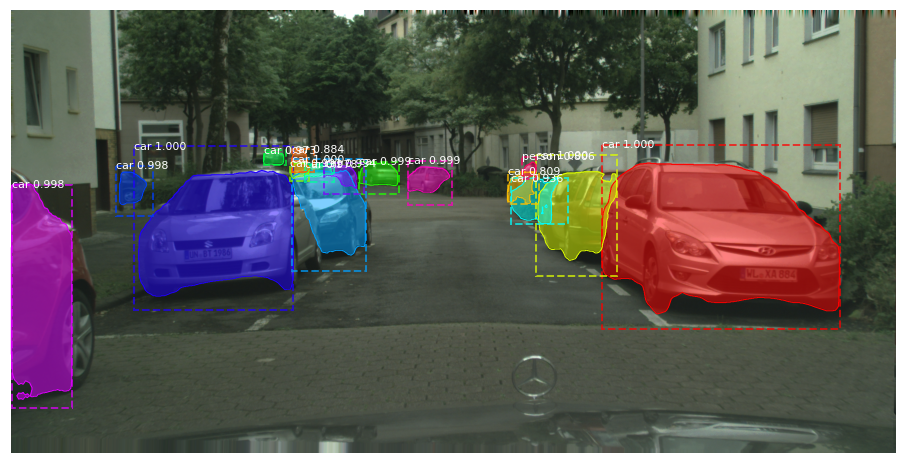

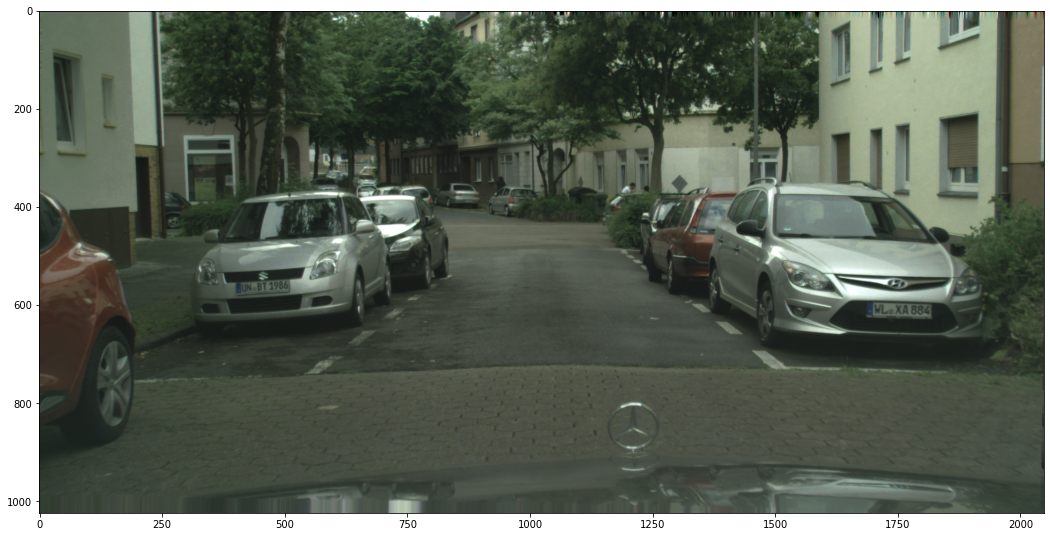

In [12]:
import os
# Load a random image from the images folder

file_names = next(os.walk(IMAGE_DIR))[2]

file = os.path.join(IMAGE_DIR, random.choice(file_names))
print(file)

image = skimage.io.imread(file)

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'], save_flag=True)

#Show original image
plt.subplots(figsize=(18, 10))
plt.imshow(image)

# Inspected Weight

In [13]:
# Show stats of all trainable weights    
visualize.display_weight_stats(model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
conv1/kernel:0,"(7, 7, 3, 64)",-0.8616,+0.8451,+0.1315
conv1/bias:0,"(64,)",-0.0002,+0.0004,+0.0001
bn_conv1/gamma:0,"(64,)",+0.0835,+2.6411,+0.5091
bn_conv1/beta:0,"(64,)",-2.3931,+5.3610,+1.9781
bn_conv1/moving_mean:0,"(64,)",-173.0470,+116.3013,+44.5654
bn_conv1/moving_variance:0*** Overflow?,"(64,)",+0.0000,+146335.3594,+21847.9668
res2a_branch2a/kernel:0,"(1, 1, 64, 64)",-0.6574,+0.3179,+0.0764
res2a_branch2a/bias:0,"(64,)",-0.0022,+0.0082,+0.0018
bn2a_branch2a/gamma:0,"(64,)",+0.2169,+1.8489,+0.4116
bn2a_branch2a/beta:0,"(64,)",-2.1180,+3.7332,+1.1786


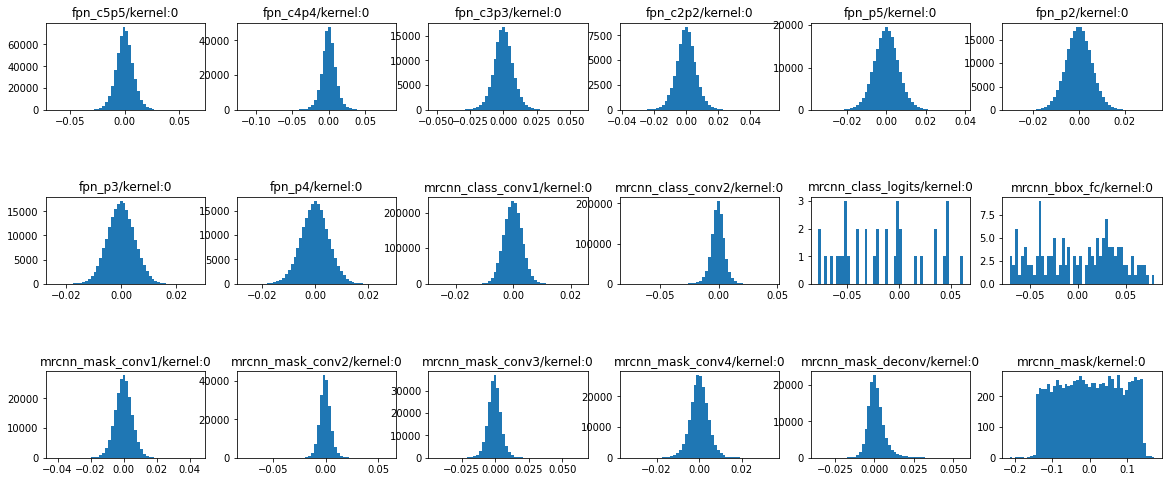

In [14]:
# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.get_trainable_layers()[-25:]
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# layers = layers[:2]
# print(len(layers))
# Display Histograms
fig, ax = plt.subplots(3, 6, figsize=(20, 8),
                       gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
#     print(int(np.floor(5/6)), l%6)
    weights = layer.get_weights()
#     for w, weight in enumerate(weights):
    weight = weights[0]
    tensor = layer.weights[0]
    ax[int(np.floor(l/6)), l%6].set_title(tensor.name)
    _ = ax[int(np.floor(l/6)), l%6].hist(weight[0].flatten(), 50)

# Backup code - another way to get the image by image_id

C:\Users\QUI TRAN\Mask_RCNN\Torreshan\images\train/aachen\aachen_000005_000019_leftImg8bit.png
Processing 1 images
image                    shape: (2048, 2048, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 2048, 2048, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 43)               min:    0.00000  max: 2048.00000


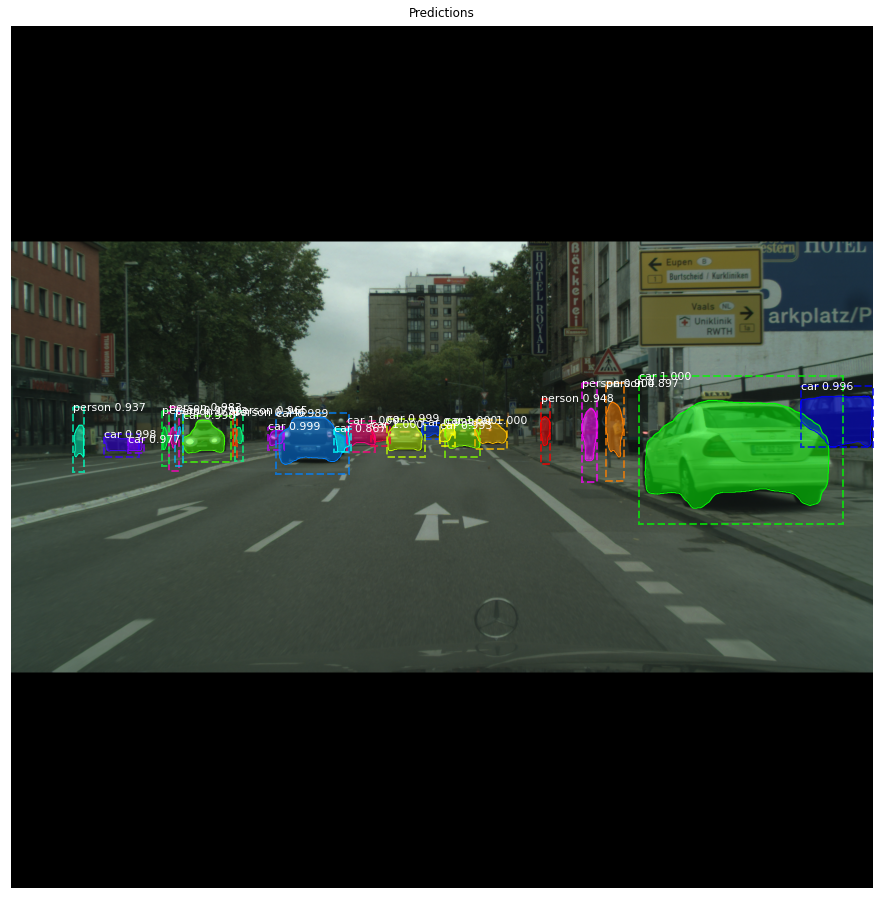

gt_class_id [32 32 24 26 24 24 24 24 26 26 24 24 26 24 26 26 26 26 26 26 26 26 26 25
 32 26 26 24 24 24]
gt_bbox [[ 971  208 1009  314]
 [ 974  195 1011  237]
 [ 898 1405 1027 1453]
 [ 949  975  964 1015]
 [ 906 1357 1032 1395]
 [ 897 1405 1029 1454]
 [ 926 1256  998 1281]
 [ 946  980  976  991]
 [ 971  208 1009  314]
 [ 974  195 1011  237]
 [ 946  148 1026  187]
 [ 950 1011  976 1025]
 [ 958  612  996  659]
 [ 959  378 1003  395]
 [ 936 1089  992 1177]
 [ 865 1500 1143 1951]
 [ 948  868  973  906]
 [ 943 1015  985 1044]
 [ 943 1024  987 1078]
 [ 952  854  987  903]
 [ 942  790  998  867]
 [ 942  895 1008  977]
 [ 944 1039 1000 1116]
 [ 931  771  998  806]
 [ 966  770 1020  804]
 [ 925  641 1035  785]
 [ 932  407 1014  512]
 [ 960  356 1006  374]
 [ 954  527  998  539]
 [ 954  540  997  557]]
gt_mask [[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]


In [15]:
image_id=5
info = dataset_train.image_info[image_id]['path']
print(info)

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, config, image_id, use_mini_mask=False)


# gt_mask from True False to 1 0
gt_mask = gt_mask*1

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'], ax=ax, title="Predictions", save_flag=True)
# visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_train.class_names, ax=ax,
#                             title="Predictions", save_flag=True)

print("gt_class_id", gt_class_id)
print("gt_bbox", gt_bbox)
print("gt_mask", gt_mask)


## confusion matrix

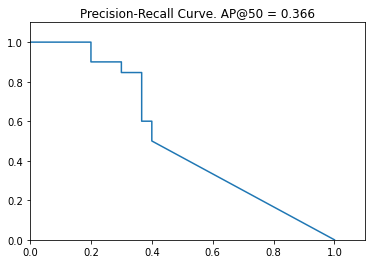

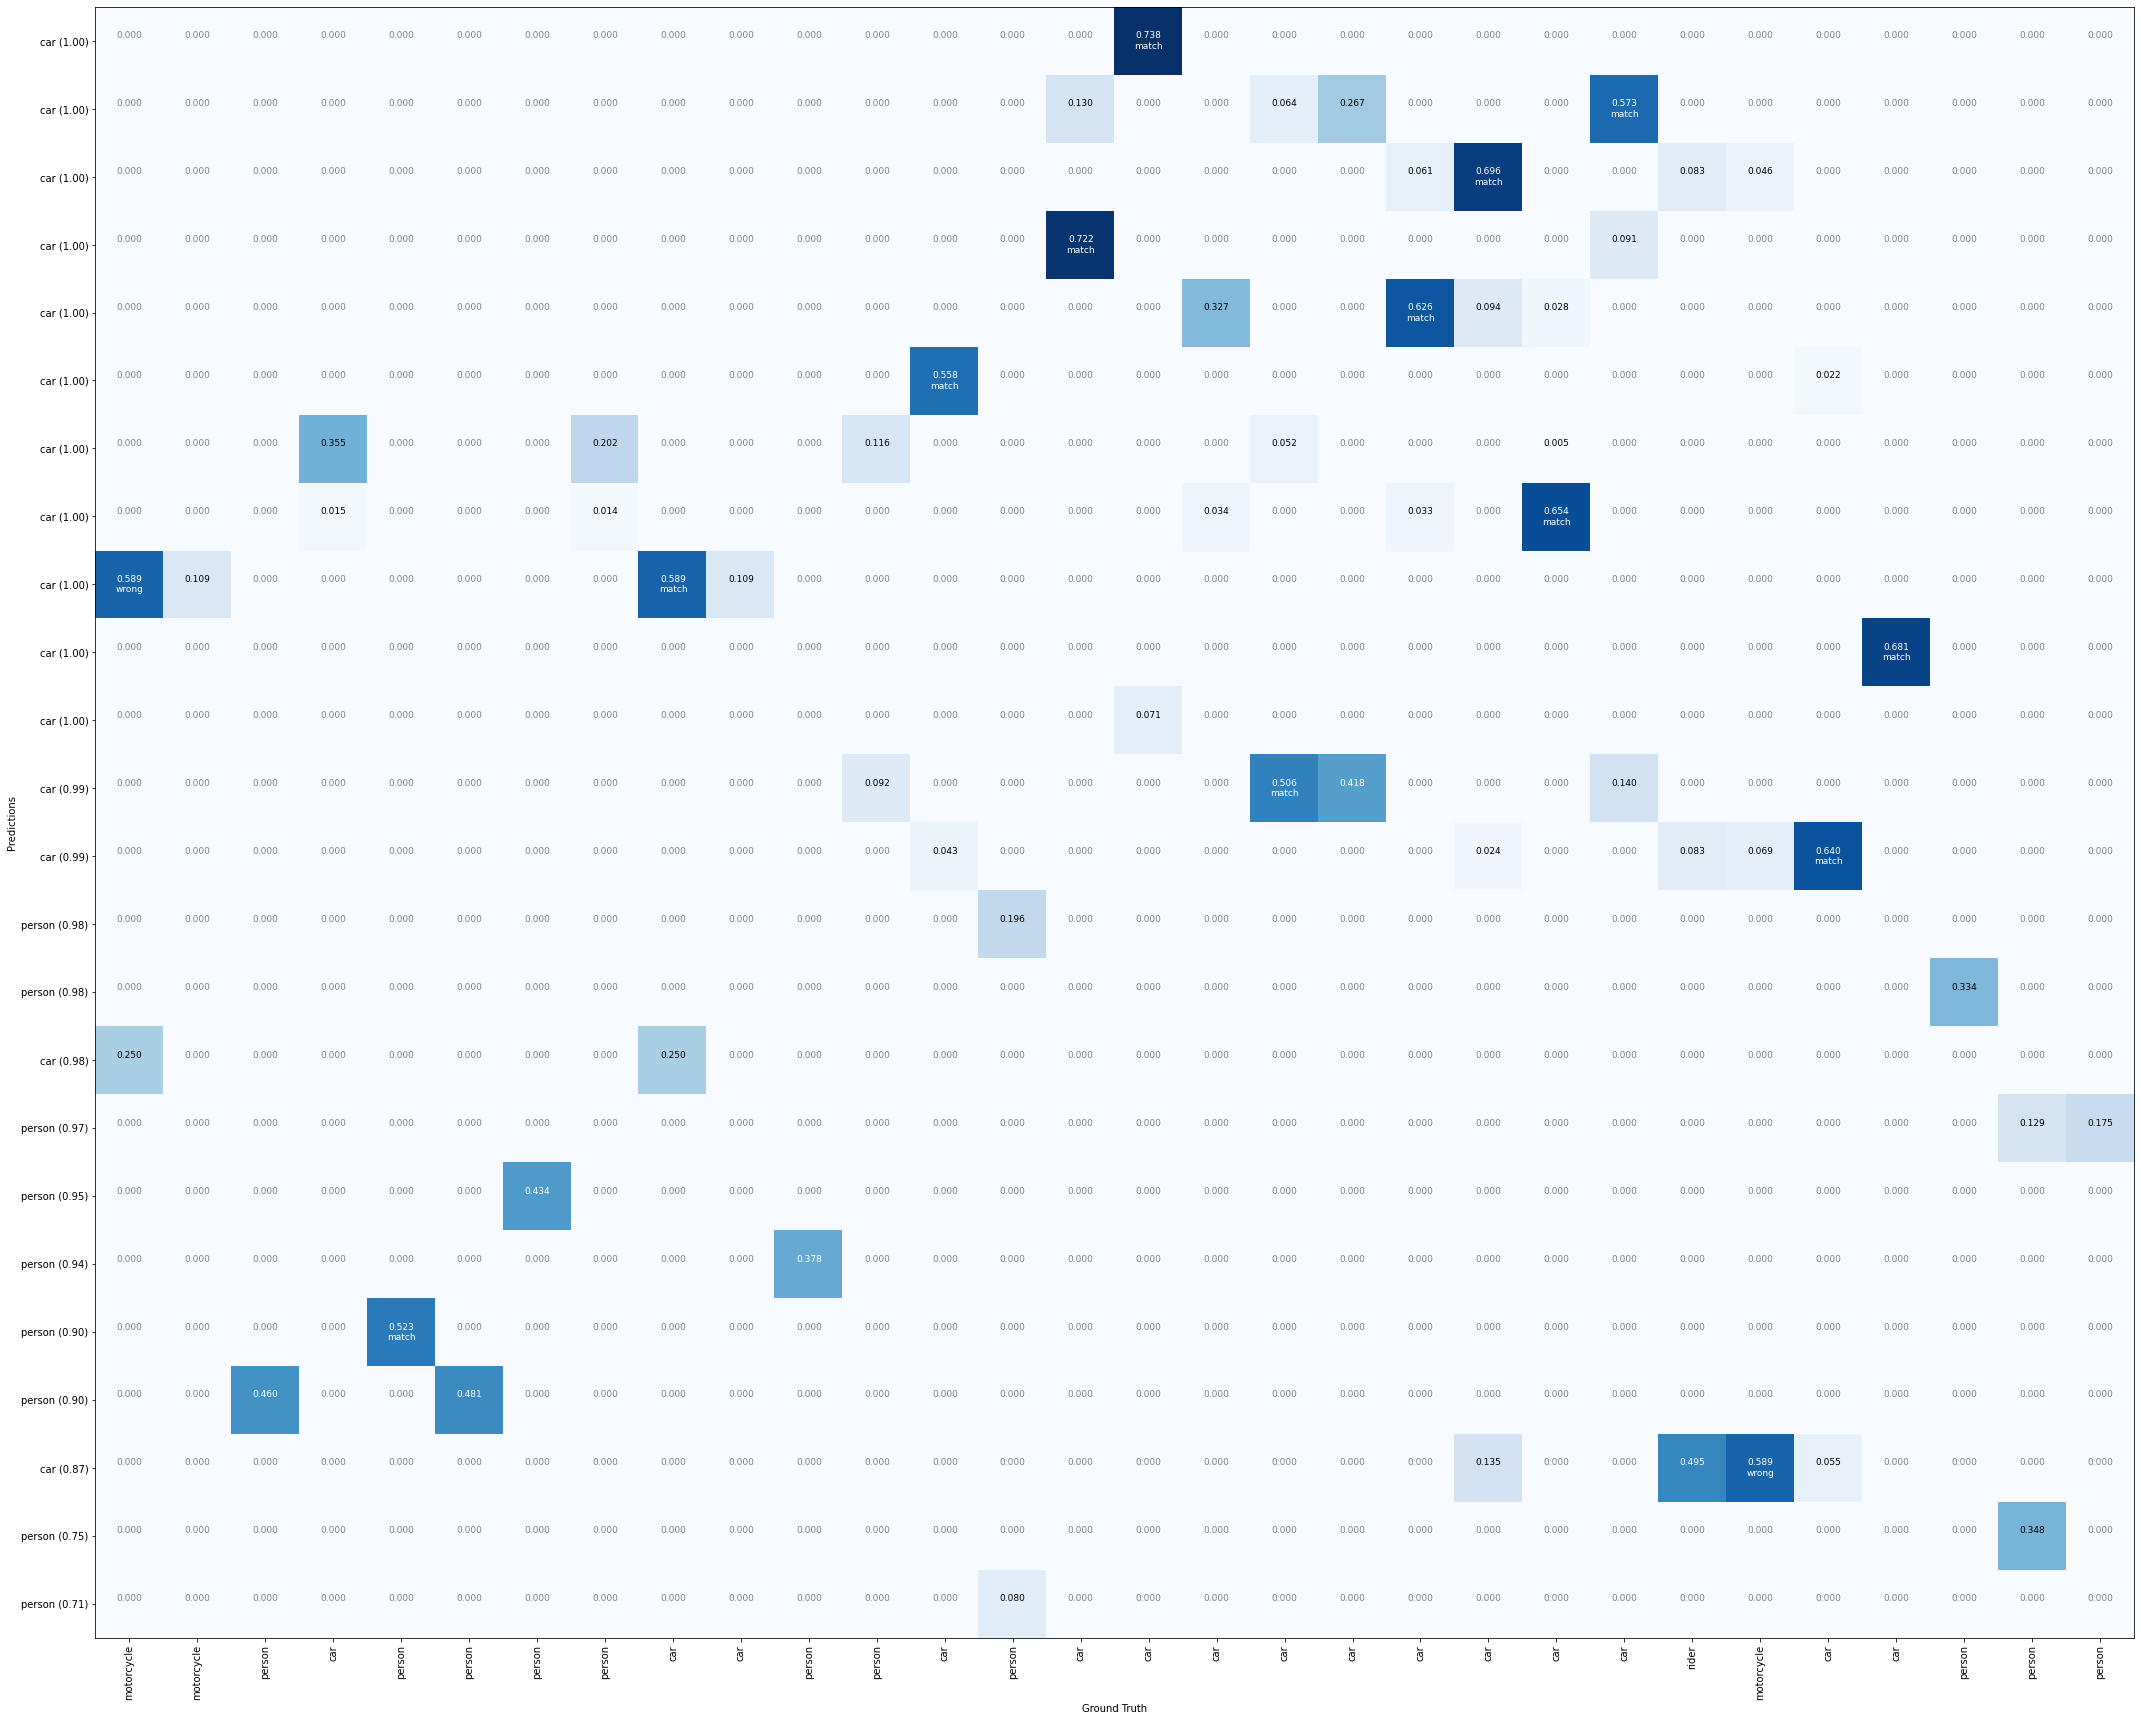

In [14]:
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, 
                                          r['rois'], r['class_ids'], r['scores'])
visualize.plot_precision_recall(AP, precisions, recalls)
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset_train.class_names, save=True)